In [10]:
from hera_sim.visibilities import VisCPU
from hera_sim import io
import autograd.numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
import copy
from pyuvsim.analyticbeam import AnalyticBeam
from pyuvdata import UVBeam
import uvtools
import time

from math import *
import random
import pymc3 as pm
import theano
import theano.tensor as tt
from autograd import elementwise_grad, jacobian

In [11]:
dist = 14.6
ants = {}

for i in range(0, 2):
        ants.update([(i, (-3.*dist/2 + i*14.6, 0., 0.))])   

In [12]:
Nant = len(ants)
ant_index = list(ants.keys())
Nant, ant_index

(2, [0, 1])

Text(0, 0.5, 'y in metre')

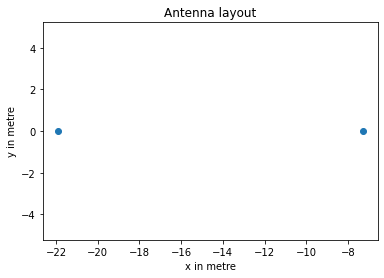

In [13]:
antscord = list(ants.values())[:]
antscord = np.array(antscord)

plt.scatter(antscord[:,0],antscord[:,1])
plt.axis('equal')
plt.title('Antenna layout')
plt.xlabel('x in metre')
plt.ylabel('y in metre')

In [14]:
nfreqs = 40 #120
ntimes = 1 #160

def myuvdata(ntimes=160, **kwargs): #160
    return io.empty_uvdata(
        nfreq = nfreqs,
        start_freq = 1.e8,
        channel_width = 0.2e8 / nfreqs,
        start_time=2458902.4,
        integration_time = 40.,
        ntimes= ntimes,
        ants = ants,
        **kwargs
    )

In [15]:
uvdata = myuvdata(ntimes)

In [16]:
bb = np.genfromtxt('catB_plain.txt',usecols=(0,1,2,3))

ra_dec = np.deg2rad(bb[:,0:2])
ra_dec.shape

(300, 2)

In [17]:
freqs = np.unique(uvdata.freq_array)
freq0 = 1.e8

flux = (freqs[:,np.newaxis]/freq0)**bb[:,3].T*bb[:,2].T
flux.shape

(40, 300)

In [18]:
beam = [AnalyticBeam("gaussian", sigma=0.103) for i in range(Nant)]

In [19]:
uvdata = myuvdata(ntimes)
simulator = VisCPU(
    uvdata = uvdata,
    beams = beam,
    beam_ids = ant_index,
    sky_freqs = freqs,
    point_source_pos = ra_dec,
    point_source_flux = flux,
    bm_pix = 20
)

In [20]:
start=time.time()
simulator.simulate()
print('Time for one simulation : '+ str(time.time()-start))

Time for one simulation : 0.04249215126037598


In [21]:
visibility = simulator.uvdata.get_data(0,1)

Text(0, 0.5, 'visibility')

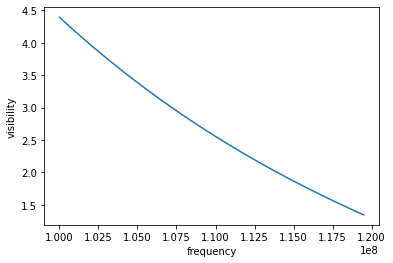

In [22]:
for i in range(ntimes) :
    myvis = visibility[i]
    plt.plot(freqs,myvis.real)
plt.xlabel('frequency')
plt.ylabel('visibility')

In [23]:
def my_visibility(sigmas,freqs) :
    uvdata = myuvdata(ntimes=1)
    beam = [AnalyticBeam("gaussian", sigma=sigmas[i]) for i in range(Nant)] #sigma=0.103
    
    simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = ant_index,
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = 20
    )
    simulator.simulate()
    visibility = simulator.uvdata.get_data(0,1)
    return [visibility[0].real, visibility[0].imag]

In [24]:
start=time.time()
sigmas = 0.103*np.ones(Nant)
true_model = my_visibility(sigmas,freqs)
data = true_model #+ 1000*np.random.randn(120)
print('Time for my_visibility() : '+ str(time.time()-start))

Time for my_visibility() : 0.08612513542175293


In [25]:
start=time.time()
sigmas = 0.103*np.ones(Nant)
true_model = my_visibility(sigmas,freqs)
data = true_model #+ 1000*np.random.randn(120)
print('Time for my_visibility() : '+ str(time.time()-start))

Time for my_visibility() : 0.08601546287536621


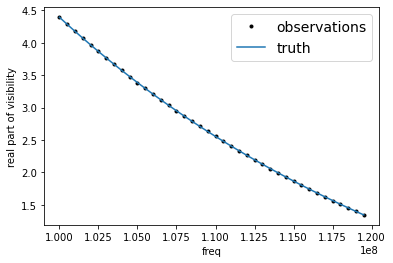

In [26]:
plt.plot(freqs,data[0], ".k", label="observations")
plt.plot(freqs, true_model[0], label="truth")
plt.xlabel("freq")
plt.ylabel("real part of visibility")
plt.legend(fontsize=14);

In [27]:
def my_model(param,nu) :
    return my_visibility(param,nu)

def my_loglike(param,nu,data,sigma) :
    model = my_model(param,nu)
    return -0.5/(sigma**2) * (np.sum(model[0] - data[0])**2 + np.sum(model[1] - data[1])**2)

def neglogprob(param) :
    return -1*my_loglike(param,100.,data,1.) ;

In [28]:
start = time.time()
test = my_loglike(sigmas,freqs,data,1.)
print(time.time()-start)

0.08616471290588379


In [33]:
from autograd import grad, elementwise_grad
import autograd.numpy as np
import scipy.stats as st
import math

#Leapfrog algorithm
def leapfrog(q,p,dVdq,path_len,step_size) :
    '''
    inputs :
    --------
    q,p (float)^D -> initial position and momentum
    dVdq (function)-> Gradient of velocity
    path_len (float) -> How long each integration path is
    step_size (float) -> How long each integration step shold be
    
    Outputs :
    ---------
    q,p -> new position and momentum
    '''
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p
    


#Hamiltonian Monte Carlo Technique 
def HMC(n_samples, negative_log_prob, initial_position, path_len=1, step_size = 0.1) :
    '''
    inputs :
    --------
    n_samples (int) -> Number of samples to return
    negative_log_prob (function) -> Negative log probability to sample from
    initial_position (np.array) -> Where we start sampling from
    path_len (float) -> How long each integration path is. Smaller is faster and more correlated.
    step_size (float) -> How long each integration step is. Smaller is slower and more accurate.
    
    Outputs :
    ---------
    An array of length n_samples
    ''' 

    dVdq = elementwise_grad(negative_log_prob)
    
    samples = [initial_position]
    
    momentum = st.norm(0, 1)
    
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=0.1,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

In [34]:
HMC(10,neglogprob,np.array([0.1,0.1]))

AttributeError: 'float' object has no attribute 'shape'

In [ ]:
"""
A number of mappings which may be useful for visibility simulators.
"""

def uvbeam_to_lm(uvbeam, freqs, n_pix_lm=63, **kwargs):
    """
    Convert a UVbeam to a uniform (l,m) grid
    Parameters
    ----------
    uvbeam : UVBeam object
        Beam to convert to an (l, m) grid.
    freqs : array_like
        Frequencies to interpolate to in [Hz]. Shape=(NFREQS,).
    n_npix_lm : int, optional
        Number of pixels for each side of the beam grid. Default is 63.
    Returns
    -------
    ndarray
        The beam map cube. Shape=(NFREQS, BEAM_PIX, BEAM_PIX).
    """

    L = np.linspace(-1, 1, n_pix_lm, dtype=np.float32)
    L, m = np.meshgrid(L, L)
    L = L.flatten()
    m = m.flatten()

    lsqr = L ** 2 + m ** 2
    n = np.where(lsqr < 1, np.sqrt(1 - lsqr), 0)

    az = -np.arctan2(m, L)
    za = np.pi/2 - np.arcsin(n)

    efield_beam = uvbeam.interp(az, za, freqs, **kwargs)[0]
    efieldXX = efield_beam[0, 0, 1]

    # Get the relevant indices of res
    bm = np.zeros((len(freqs), len(L)))

    bm = efieldXX

    if np.max(bm) > 0:
        bm /= np.max(bm)

    return bm.reshape((len(freqs), n_pix_lm, n_pix_lm))


def eq2top_m(ha, dec):
    """
    Calculates the equatorial to topocentric conversion matrix.
    
    Conversion at a given hour angle (ha) and declination (dec). Ripped 
    straight from aipy.
    
    Parameters
    ----------
    ha : float
        Hour angle [rad].
    dec : float
        Declination [rad].
    Returns
    -------
    ndarray
        Coordinate transform matrix converting equatorial coordinates to
        topocentric coordinates. Shape=(3, 3).
    """
    sin_H, cos_H = np.sin(ha), np.cos(ha)
    sin_d, cos_d = np.sin(dec), np.cos(dec)
    zero = np.zeros_like(ha)

    map = np.array([[sin_H, cos_H, zero],
                    [-sin_d * cos_H, sin_d * sin_H, cos_d],
                    [cos_d * cos_H, -cos_d * sin_H, sin_d]])

    if len(map.shape) == 3:
        map = map.transpose([2, 0, 1])

    return map


def healpix_to_crd_eq(h, nest=False):
    """
    Determine equatorial co-ordinates of a healpix map's pixels.
    Parameters
    ----------
    h : array_like
        The HEALPix array. Shape=(12*N^2,) for integer N.
    nest : bool, optional
        Whether to use the NEST configuration for the HEALPix array.
    Returns
    -------
    ndarray
       The equatorial coordinates of each HEALPix pixel. 
       Shape=(12*N^2, 3) for integer N.
    """
    assert h.ndim == 1, "h must be a 1D array."

    px = np.arange(len(h))
    crd_eq = np.array(healpy.pix2vec(healpy.get_nside(h), px, nest=nest),
                      dtype=np.float32)
    return crd_eq


def lm_to_az_za(l, m):
    """
    Convert l and m (on intervals -1, +1) to azimuth and zenith angle.
    
    Parameters
    ----------
    l, m : array_like
        Normalized angular coordinates on the interval (-1, +1).
    
    Returns
    -------
    az, za : array_like
        Corresponding azimuth and zenith angles (in radians).
    """
    lsqr = l**2. + m**2.
    n = np.where(lsqr < 1., np.sqrt(1. - lsqr), 0.)
    
    az = -np.arctan2(m, l)
    za = np.pi/2. - np.arcsin(n)
    return az, za

In [ ]:
from __future__ import division
from builtins import range
import autograd.numpy as np
from scipy.interpolate import RectBivariateSpline
import healpy


from hera_sim.visibilities.simulators import VisibilitySimulator

from astropy.constants import c

class VisCPU(VisibilitySimulator):
    """
    vis_cpu visibility simulator.
    This is a fast, simple visibility simulator that is intended to be
    replaced by vis_gpu. It extends :class:`VisibilitySimulator`.
    """

    def __init__(self, bm_pix=100, use_pixel_beams=True,use_gpu=False, precision=1,
                 mpi_comm=None, **kwargs):
        """
        Parameters
        ----------
        bm_pix : int, optional
            The number of pixels along a side in the beam map when
            converted to (l, m) coordinates. Defaults to 100.
        use_pixel_beams : bool, optional
            Whether to use primary beams that have been pixelated onto a 2D 
            grid, or directly evaluate the primary beams using the available 
            UVBeam objects. Default: True.
        precision : int, optional
            Which precision level to use for floats and complex numbers. 
            Allowed values:
                - 1: float32, complex64
                - 2: float64, complex128
            Default: 1.
        mpi_comm : MPI communicator
            MPI communicator, for parallelization.
        **kwargs
            Arguments of :class:`VisibilitySimulator`.
        """
        assert precision in (1,2)
        self._precision = precision
        if precision == 1:
            self._real_dtype = np.float32
            self._complex_dtype = np.complex64
        else:
            self._real_dtype = np.float64
            self._complex_dtype = np.complex128

        if use_gpu:
            try:
                from hera_gpu.vis import vis_gpu
                self._vis_cpu = vis_gpu
            except ImportError:
                raise ImportError(
                    'GPU acceleration requires hera_gpu (`pip install hera_sim[gpu]`).'
                )
        else:
            self._vis_cpu = vis_cpu
        
        self.bm_pix = bm_pix
        self.use_pixel_beams = use_pixel_beams
        self.mpi_comm = mpi_comm
        
        super(VisCPU, self).__init__(**kwargs)

        # Convert some arguments to forms more simple for vis_cpu.
        self.antpos = self.uvdata.get_ENU_antpos()[0].astype(self._real_dtype)
        self.freqs = self.uvdata.freq_array[0]

    @property
    def lsts(self):
        """
        Sets LSTs from uvdata if not already set.
        Returns
        -------
        array_like
            LSTs of observations. Shape=(NTIMES,).
        """
        try:
            return self.__lsts
        except AttributeError:
            self.__lsts = self.uvdata.lst_array[::self.uvdata.Nbls]

            return self.__lsts

    def validate(self):
        """Checks for correct input format."""
        super(VisCPU, self).validate()

        # This one in particular requires that every baseline is used!
        N = len(self.uvdata.antenna_numbers)
        # N(N-1)/2 unique cross-correlations + N autocorrelations.
        if len(self.uvdata.get_antpairs()) != N * (N + 1) / 2:
            raise ValueError("VisCPU requires using every pair of antennas, "
                             "but the UVData object does not comply.")

        if (len(self.uvdata.data_array) != len(self.uvdata.get_antpairs())
                * len(self.lsts)):
            raise ValueError("VisCPU requires that every baseline uses the "
                             "same LSTS.")

    def get_beam_lm(self):
        """
        Obtain the beam pattern in (l,m) co-ordinates for each antenna.
        Returns
        -------
        array_like
            The beam pattern in (l,m) for each antenna.
            Shape=(NANT, BM_PIX, BM_PIX).
        Notes
        -----
            Due to using the verbatim :func:`vis_cpu` function, the beam
            cube must have an entry for each antenna, which is a bit of
            a waste of memory in some cases. If this is changed in the
            future, this method can be modified to only return one
            matrix for each beam.
        """
        return np.asarray([
            uvbeam_to_lm(
                self.beams[self.beam_ids[i]], self.freqs, self.bm_pix
            ) for i in range(self.n_ant)
        ])

    def get_diffuse_crd_eq(self):
        """
        Calculate equatorial coords of HEALPix sky pixels (Cartesian).
        Returns
        -------
        array_like of self._real_dtype
            The equatorial co-ordinates of each pixel.
            Shape=(12*NPIX^2, 3).
        """
        diffuse_eq = healpix_to_crd_eq(self.sky_intensity[0])
        return diffuse_eq.astype(self._real_dtype)

    def get_point_source_crd_eq(self):
        """
        Calculate approximate HEALPix map of point sources.
        Returns
        -------
        array_like
            equatorial coordinates of Healpix pixels, in Cartesian
            system. Shape=(3, NPIX).
        """
        ra, dec = self.point_source_pos.T
        return np.asarray([np.cos(ra)*np.cos(dec), np.cos(dec)*np.sin(ra),
                         np.sin(dec)])

    def get_eq2tops(self):
        """
        Calculate transformations from equatorial to topocentric coords.
        Returns
        -------
        array_like of self._real_dtype
            The set of 3x3 transformation matrices converting equatorial
            to topocenteric co-ordinates at each LST.
            Shape=(NTIMES, 3, 3).
        """

        sid_time = self.lsts
        eq2tops = np.empty((len(sid_time), 3, 3), dtype=self._real_dtype)

        for i, st in enumerate(sid_time):
            dec = self.uvdata.telescope_location_lat_lon_alt[0]
            eq2tops[i] = eq2top_m(-st, dec)

        return eq2tops

    def _base_simulate(self, crd_eq, I):
        """
        Calls :func:vis_cpu to perform the visibility calculation.
        Returns
        -------
        array_like of self._complex_dtype
            Visibilities. Shape=self.uvdata.data_array.shape.
        """
        # Setup MPI info if enabled
        if self.mpi_comm is not None:
            myid = self.mpi_comm.Get_rank()
            nproc = self.mpi_comm.Get_size()
        
        # Convert equatorial to topocentric coords
        eq2tops = self.get_eq2tops()
        
        # Get pixelized beams if required
        if self.use_pixel_beams:
            beam_lm = self.get_beam_lm()
        else:
            beam_list = [self.beams[self.beam_ids[i]] for i in range(self.n_ant)]
            
        visfull = np.zeros_like(self.uvdata.data_array,
                                dtype=self._complex_dtype)
        
        for i, freq in enumerate(self.freqs):
            
            # Divide tasks between MPI workers if needed
            if self.mpi_comm is not None:
                if i % nproc != myid: continue
            
            if self.use_pixel_beams:
                # Use pixelized primary beams
                vis = vis_cpu(
                    antpos=self.antpos,
                    freq=freq,
                    eq2tops=eq2tops,
                    crd_eq=crd_eq,
                    I_sky=I[i],
                    bm_cube=beam_lm[:, i],
                    precision=self._precision
                )
            else:
                # Use UVBeam objects directly
                vis = vis_cpu(
                    antpos=self.antpos,
                    freq=freq,
                    eq2tops=eq2tops,
                    crd_eq=crd_eq,
                    I_sky=I[i],
                    beam_list=beam_list,
                    precision=self._precision
                )

            indices = np.triu_indices(vis.shape[1])
            vis_upper_tri = vis[:, indices[0], indices[1]]

            visfull[:, 0, i, 0] = vis_upper_tri.flatten()
        
        # Reduce visfull array if in MPI mode
        if self.mpi_comm is not None:
            from mpi4py.MPI import SUM
            _visfull = np.zeros(visfull.shape, dtype=visfull.dtype)
            self.mpi_comm.Reduce(visfull, _visfull, op=SUM, root=0)
            if myid == 0:
                return _visfull
            else:
                return 0 # workers return 0
            
        return visfull

    def _simulate_diffuse(self):
        """
        Simulate diffuse sources.
        Returns
        -------
        array_like
            Visibility from point sources.
            Shape=self.uvdata.data_array.shape.
        """
        crd_eq = self.get_diffuse_crd_eq()
        # Multiply intensity by pix area because the algorithm doesn't.
        return self._base_simulate(
            crd_eq,
            self.sky_intensity * healpy.nside2pixarea(self.nside)
        )

    def _simulate_points(self):
        """
        Simulate point sources.
        Returns
        -------
        array_like
            Visibility from diffuse sources.
            Shape=self.uvdata.data_array.shape.
        """
        crd_eq = self.get_point_source_crd_eq()
        return self._base_simulate(crd_eq, self.point_source_flux)

    def _simulate(self):
        """
        Simulate diffuse and point sources.
        Returns
        -------
        array_like
            Visibility from all sources.
            Shape=self.uvdata.data_array.shape.
        """
        vis = 0
        if self.sky_intensity is not None:
            vis += self._simulate_diffuse()
        if self.point_source_flux is not None:
            vis += self._simulate_points()
        return vis


def vis_cpu(antpos, freq, eq2tops, crd_eq, I_sky, bm_cube=None, beam_list=None,
            precision=1):
    """
    Calculate visibility from an input intensity map and beam model.
    Provided as a standalone function.
    Parameters
    ----------
    antpos : array_like
        Antenna position array. Shape=(NANT, 3).
    freq : float
        Frequency to evaluate the visibilities at [GHz].
    eq2tops : array_like
        Set of 3x3 transformation matrices converting equatorial
        coordinates to topocentric at each
        hour angle (and declination) in the dataset.
        Shape=(NTIMES, 3, 3).
    crd_eq : array_like
        Equatorial coordinates of Healpix pixels, in Cartesian system.
        Shape=(3, NPIX).
    I_sky : array_like
        Intensity distribution on the sky,
        stored as array of Healpix pixels. Shape=(NPIX,).
    bm_cube : array_like, optional
        Pixelized beam maps for each antenna. Shape=(NANT, BM_PIX, BM_PIX).
    beam_list : list of UVBeam, optional
        If specified, evaluate primary beam values directly using UVBeam 
        objects instead of using pixelized beam maps (`bm_cube` will be ignored 
        if `beam_list` is not None).
    precision : int, optional
        Which precision level to use for floats and complex numbers. 
        Allowed values:
            - 1: float32, complex64
            - 2: float64, complex128
        Default: 1.
    Returns
    -------
    array_like
        Visibilities. Shape=(NTIMES, NANTS, NANTS).
    """
    assert precision in (1,2)
    if precision == 1:
        real_dtype=np.float32
        complex_dtype=np.complex64
    else:
        real_dtype=np.float64
        complex_dtype=np.complex128
    
    nant, ncrd = antpos.shape
    assert ncrd == 3, "antpos must have shape (NANTS, 3)."
    ntimes, ncrd1, ncrd2 = eq2tops.shape
    assert ncrd1 == 3 and ncrd2 == 3, "eq2tops must have shape (NTIMES, 3, 3)."
    ncrd, npix = crd_eq.shape
    assert ncrd == 3, "crd_eq must have shape (3, NPIX)."
    assert I_sky.ndim == 1 and I_sky.shape[0] == npix, \
        "I_sky must have shape (NPIX,)."
    
    if beam_list is None:
        bm_pix = bm_cube.shape[-1]
        assert bm_cube.shape == (
            nant,
            bm_pix,
            bm_pix,
        ), "bm_cube must have shape (NANTS, BM_PIX, BM_PIX)."
    else:
        assert len(beam_list) == nant, "beam_list must have length nant"

    # Intensity distribution (sqrt) and antenna positions. Does not support
    # negative sky.
    Isqrt = np.sqrt(I_sky).astype(real_dtype)
    antpos = antpos.astype(real_dtype)

    ang_freq = 2 * np.pi * freq

    # Empty arrays: beam pattern, visibilities, delays, complex voltages.
    A_s = np.empty((nant, npix), dtype=real_dtype)
    vis = np.empty((ntimes, nant, nant), dtype=complex_dtype)
    tau = np.empty((nant, npix), dtype=real_dtype)
    v = np.empty((nant, npix), dtype=complex_dtype)
    crd_eq = crd_eq.astype(real_dtype)
    
    # Precompute splines is using pixelized beams
    if beam_list is None:
        bm_pix_x = np.linspace(-1, 1, bm_pix)
        bm_pix_y = np.linspace(-1, 1, bm_pix)
    
        splines = []
        for i in range(nant):
            # Linear interpolation of primary beam pattern.
            spl = RectBivariateSpline(bm_pix_y, bm_pix_x, bm_cube[i], kx=1, ky=1)
            splines.append(spl)
    
    # Loop over time samples
    for t, eq2top in enumerate(eq2tops.astype(real_dtype)):
        tx, ty, tz = crd_top = np.dot(eq2top, crd_eq)
        
        # Primary beam response
        if beam_list is None:
            # Primary beam pattern using pixelized primary beam
            for i in range(nant):
                A_s[i] = splines[i](ty, tx, grid=False)
                # FIXME: Try using a log-space beam for accuracy!
        else:
            # Primary beam pattern using direct interpolation of UVBeam object
            az, za = lm_to_az_za(ty, tx) # FIXME: Order of tx, ty
            for i in range(nant):
                interp_beam = beam_list[i].interp(az, za, np.atleast_1d(freq))[0]
                A_s[i] = interp_beam[0,0,1] # FIXME: assumes xx pol for now
        
        A_s = np.where(tz > 0, A_s, 0)

        # Calculate delays, where tau = (b * s) / c.
        np.dot(antpos, crd_top, out=tau)
        tau /= c.value

        np.exp(1.j * (ang_freq * tau), out=v)

        # Complex voltages.
        v *= A_s * Isqrt

        # Compute visibilities using product of complex voltages (upper triangle).
        for i in range(len(antpos)):
            np.dot(v[i:i+1].conj(), v[i:].T, out=vis[t, i:i+1, i:])

    return vis

In [ ]:
# -*- mode: python; coding: utf-8 -*
# Copyright (c) 2018 Radio Astronomy Software Group
# Licensed under the 3-clause BSD License

import warnings

import pyuvdata.utils as uvutils
from scipy.special import j1
from astropy.constants import c as speed_of_light

c_ms = speed_of_light.to('m/s').value


def diameter_to_sigma(diam, freqs):
    """
    Find the stddev of a gaussian with fwhm equal to that of
    an Airy disk's main lobe for a given diameter.
    Args:
        diam: Antenna diameter in meters
        freqs: Array of frequencies, in Hz
    Returns:
        sigma: The standard deviation in zenith angle radians for a Gaussian beam
               with FWHM equal to that of an Airy disk's main lobe for an aperture
               with the given diameter.
    """

    wavelengths = c_ms / freqs

    scalar = 2.2150894  # Found by fitting a Gaussian to an Airy disk function

    sigma = np.arcsin(scalar * wavelengths / (np.pi * diam)) * 2 / 2.355

    return sigma


class AnalyticBeam(object):
    """
    Defines an object with similar functionality to pyuvdata.UVBeam
    Directly calculates jones matrices at given azimuths and zenith angles
    from analytic functions.
    Args:
        type: str, {'uniform', 'airy', 'gaussian'}
            Beam type to use. Supported types:
            * Uniform beam: Unit response from all directions.
            * Airy: An Airy disk pattern (the 2D Fourier transform of a circular aperture of
              width given by `diameter`)
            * Gaussian: A peak-normalized gaussian function.
                * If given a `diameter`, then this makes a chromatic beam with FWHMs
                  matching an equivalent Airy disk beam at each frequency.
                * If given a `sigma`, this makes an achromatic beam with standard deviation
                  set to `sigma`
                * If given a `sigma`, `ref_freq`, and `spectral_index`, then this will make
                  a chromatic beam with standard deviation defined by a power law:
                  `stddev(f) = sigma * (f/ref_freq)**(spectral_index)`
        sigma: (float)
            standard deviation [radians] for gaussian beam
            When spectral index is set, this represents the FWHM at the ref_freq.
        spectral_index : (float, optional)
            Scale gaussian beam width as a power law with frequency.
        ref_freq : (float, optional)
            If set, this sets the reference frequency for the beam width power law.
    """

    supported_types = ['uniform', 'gaussian', 'airy']

    def __init__(self, type, sigma=None, diameter=None, spectral_index=0.0, ref_freq=None):
        if type in self.supported_types:
            self.type = type
        else:
            raise ValueError('type not recognized')

        self.sigma = sigma
        if self.type == 'gaussian' and self.sigma is not None:
            warnings.warn("Achromatic gaussian beams will not be supported in the future. "
                          + "Define your gaussian beam by a dish diameter from now on.",
                          PendingDeprecationWarning)

        if (spectral_index != 0.0) and (ref_freq is None):
            raise ValueError("ref_freq must be set for nonzero gaussian beam spectral index")
        elif ref_freq is None:
            ref_freq = 1.0
        self.ref_freq = ref_freq
        self.spectral_index = spectral_index
        self.diameter = diameter
        self.data_normalization = 'peak'
        self.freq_interp_kind = 'linear'
        self.beam_type = 'efield'

    def peak_normalize(self):
        pass

    def efield_to_power(self):
        """
        Tell interp to return values corresponding with a power beam.
        """

        self.beam_type = 'power'
        pol_strings = ['XX', 'XY', 'YX', 'YY']
        self.polarization_array = np.array([uvutils.polstr2num(ps.upper()) for ps in pol_strings])

    def interp(self, az_array, za_array, freq_array, reuse_spline=None, spline_opts=None):
        """
        Evaluate the primary beam at given az, za locations (in radians).
        (similar to UVBeam.interp)
        Args:
            az_array: az values to evaluate at in radians (same length as za_array)
                The azimuth here has the UVBeam convention: North of East(East=0, North=pi/2)
            za_array: za values to evaluate at in radians (same length as az_array)
            freq_array: frequency values to evaluate at
            reuse_spline: Does nothing for analytic beams. Here for compatibility with UVBeam.
        Returns:
            an array of beam values, shape (Naxes_vec, Nspws, Nfeeds or Npols,
                Nfreqs or freq_array.size if freq_array is passed,
                Npixels/(Naxis1, Naxis2) or az_array.size if az/za_arrays are passed)
            an array of interpolated basis vectors (or self.basis_vector_array
                if az/za_arrays are not passed), shape: (Naxes_vec, Ncomponents_vec,
                Npixels/(Naxis1, Naxis2) or az_array.size if az/za_arrays are passed)
        """

        if self.type == 'uniform':
            interp_data = np.zeros((2, 1, 2, freq_array.size, az_array.size), dtype=np.float)
            interp_data[1, 0, 0, :, :] = 1
            interp_data[0, 0, 1, :, :] = 1
            interp_data[1, 0, 1, :, :] = 0
            interp_data[0, 0, 0, :, :] = 0

            # If beam_type == "power", we need to know the shape of "values"
            values = interp_data[0, 0, 0]

            interp_basis_vector = None
        elif self.type == 'gaussian':
            if (self.diameter is None) and (self.sigma is None):
                raise ValueError("Dish diameter needed for gaussian beam -- units: meters")
            interp_data = np.zeros((2, 1, 2, freq_array.size, az_array.size), dtype=np.float)
            # gaussian beam only depends on Zenith Angle (symmetric is azimuth)
            # standard deviation of sigma is referring to the standard deviation of e-field beam!
            # copy along freq. axis
            if self.diameter is not None:
                sigmas = diameter_to_sigma(self.diameter, freq_array)
            elif self.sigma is not None:
                sigmas = self.sigma * (freq_array / self.ref_freq) ** self.spectral_index
            values = np.exp(-(za_array[np.newaxis, ...] ** 2) / (2 * sigmas[:, np.newaxis] ** 2))
            interp_data[1, 0, 0, :, :] = values
            interp_data[0, 0, 1, :, :] = values
            interp_basis_vector = None
        elif self.type == 'airy':
            if self.diameter is None:
                raise ValueError("Dish diameter needed for airy beam -- units: meters")
            interp_data = np.zeros((2, 1, 2, freq_array.size, az_array.size), dtype=np.float)
            za_grid, f_grid = np.meshgrid(za_array, freq_array)
            xvals = self.diameter / 2. * np.sin(za_grid) * 2. * np.pi * f_grid / c_ms
            values = np.zeros_like(xvals)
            nz = xvals != 0.
            ze = xvals == 0.
            values[nz] = 2. * j1(xvals[nz]) / xvals[nz]
            values[ze] = 1.
            interp_data[1, 0, 0, :, :] = values
            interp_data[0, 0, 1, :, :] = values
            interp_basis_vector = None
        else:
            raise ValueError('no interp for this type: {}'.format(self.type))

        if self.beam_type == 'power':
            # Cross-multiplying feeds, adding vector components
            pairs = [(i, j) for i in range(2) for j in range(2)]
            power_data = np.zeros((1, 1, 4) + values.shape, dtype=np.float)
            for pol_i, pair in enumerate(pairs):
                power_data[:, :, pol_i] = ((interp_data[0, :, pair[0]]
                                           * np.conj(interp_data[0, :, pair[1]]))
                                           + (interp_data[1, :, pair[0]]
                                           * np.conj(interp_data[1, :, pair[1]])))
            interp_data = power_data

        return interp_data, interp_basis_vector

    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False
        if self.type == 'gaussian':
            return ((self.type == other.type)
                    and (self.sigma == other.sigma))
        elif self.type == 'uniform':
            return other.type == 'uniform'
        elif self.type == 'airy':
            return ((self.type == other.type)
                    and (self.diameter == other.diameter))
        else:
            return False

In [ ]:
import warnings

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In [ ]:
def gradients_opt(vals, func) :
    return gradients(vals, func)
    

In [ ]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.nu, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        param, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(param, self.nu, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        param, = inputs  # our parameters
        return [g[0]*self.logpgrad(param)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        param, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.nu, self.data, self.sigma)

        # calculate gradients
        grads = gradients_opt(param, lnlike) #jacobian(lnlike)#elementwise_grad(lnlike)#

        outputs[0][0] = grads

In [ ]:
ndraws = 100
# create our Op
logl = LogLikeWithGrad(my_loglike, data, freqs, 1.)

# use PyMC3 to sampler from log-likelihood
with pm.Model() as UNIFORM_9_11:
    param = []
    # Gaussian priors on parameters
    for i in range(Nant) :
        sigma_i = pm.Uniform('theta_'+str(i+1),lower=0.09, upper=0.12)  #0.09, 0.12 - 1 chain 400 samples
        param.append(sigma_i)
    
    # convert a and b to a tensor vector
    param_tensor = tt.as_tensor_variable(param)

    #use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': param_tensor})

    trace = pm.sample(ndraws,chains=1) #, tune=nburn, discard_tuned_samples=False, step=pm.HamiltonianMC()

In [ ]:
# plot the traces
pm.traceplot(trace)